<a href="https://colab.research.google.com/github/ericburdett/named-entity-recognition/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named-Entity-Recognition in TensorFlow 2


## Imports and Dependencies

TensorFlow Addons apparently has an implementation of CRF that is compatible with TF2 and tf.keras.

In [0]:
# Used in Colab to say we're using Version 2
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
# TensorFlow
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras as K
import tensorflow.keras.layers as L

# Python
import os
import string

# Data Structures
import numpy as np
import pandas as pd
import json

# Image/Plotting
from matplotlib import pyplot as plt

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode='Plain', color_scheme='LightBg', tb_offset=1) # Change to 'Verbose' mode for additional debugging

In [0]:
# Insert file path to Esposalles Dataset in your Google Drive
# Note that '!' indicates a shell command rather than python code...

!wget -q https://raw.githubusercontent.com/ericburdett/named-entity-recognition/master/char_set.json
!wget -q https://raw.githubusercontent.com/ericburdett/named-entity-recognition/master/esposalles-labels.csv

## Generator Creation

TensorFlow uses Generators to access the dataset during training

In [0]:
class Encoder():
  def __init__(self, entity_list, sequence_size=20):
    self.entity_dict = {e: i for i, e in enumerate(entity_list)}
    self.sequence_size = sequence_size

    with open('char_set.json') as file:
      self.char_dict = json.load(file)
    
  def char_to_idx(self, char):
    if char in self.char_dict['char_to_idx']:
      return int(self.char_dict['char_to_idx'][char])
    else:
      return 0
  
  def idx_to_char(self, idx):
    if str(int(idx)) in self.char_dict['idx_to_char']:
      return self.char_dict['idx_to_char'][str(int(idx))]
    else:
      return ''
  
  def str_to_idxs(self, string):
    assert type(string) == str

    zeros = np.zeros(self.sequence_size)
    idxs = []
    for char in string:
      idxs.append(self.char_to_idx(char))
    
    idxs = np.concatenate((idxs, zeros))[:self.sequence_size]

    return idxs
  
  def idxs_to_str(self, idxs):
    chars = ''

    for idx in idxs:
      chars += self.idx_to_char(idx)
    
    return chars

  def entity_to_idx(self, entity):
    return self.entity_dict[entity]

In [0]:
# TensorFlow uses Generators to access the dataset during training

def dataset_df(path='/content/esposalles-labels.csv'):
  if not os.path.exists(path):
    raise Exception('Esposalles dataset does not exist in ' + path)
  
  df = pd.read_csv(path, header=None, sep='\t', names=['img', 'entity', 'rel-entity', 'word', 'sentence'])
  df = df.drop(columns=['img'])

  return df

def encode_word_label(data, entity_type, encoder):
  word = data['word']
  encoded_word = encoder.str_to_idxs(str(word))
  label = data[entity_type]
  encoded_label = encoder.entity_to_idx(label)

  return (encoded_word, encoded_label)

def esposalles_generator(entity_type='entity'): # options include 'entity' and 'rel-entity'
  data = dataset_df()
  entity_list = list(set(data[entity_type].values))
  encoder = Encoder(entity_list)

  df_size = data['sentence'].max() + 1

  for i in range(df_size):
    ith_sentence_words = data.loc[data['sentence'] == i]

    sentence_words = []
    sentence_labels = []

    for index, row in ith_sentence_words.iterrows():
      encoded_word, encoded_label = encode_word_label(row, entity_type, encoder)
      sentence_words.append(encoded_word)
      sentence_labels.append(encoded_label)
    
    yield tf.constant(np.array(sentence_words), dtype=tf.int64), tf.constant(np.array(sentence_labels), dtype=tf.int32)

## Model Architecture

This is where we can build our model using the tf.keras high-level API

We subclass from tf.keras.Model and implement the *call* method. This is the *forward pass* of the neural network.

In [0]:
class NERModel(K.Model):
  def __init__(self, input_dim=197, num_classes=6, input_length=20):
    super(NERModel, self).__init__()

    self.embedding = L.Embedding(input_dim=input_dim, output_dim=64, input_length=input_length)
    self.lstm = L.Bidirectional(L.LSTM(64))
    self.fc1 = L.Dense(64, activation='relu')
    self.fc2 = L.Dense(num_classes)
    self.softmax = L.Softmax(axis=1)

  def call(self, x):
    out = self.embedding(x)
    out = self.lstm(out)
    out = self.fc1(out)
    out = self.fc2(out)
    out = self.softmax(out)

    return out

### Test to make sure the model is doing what we think it is...

In [6]:
generator = esposalles_generator()
sentence, labels = next(generator)

model = NERModel()
results = model(sentence)
print('Shape of output from NER Model: ', results.shape)
print('Probability Distribution for one word in the sentence: ', results[0])
print('Predicted class for the word: ', tf.argmax(results[0]))

Shape of output from NER Model:  (41, 6)
Probability Distribution for one word in the sentence:  tf.Tensor([0.1640126  0.17580101 0.16637379 0.16650574 0.16129099 0.16601591], shape=(6,), dtype=float32)
Predicted class for the word:  tf.Tensor(1, shape=(), dtype=int64)


## Training Loop

Build our training loop and creating custom train_step and test_step functions.

GradientTape allows us to keep track of the losses and gradients for each pass through the network. Structuring our code this way makes it much easier for debugging purposes and for us to iterate through our design.

Notice the decorator *@tf.function*. This tells TensorFlow to create the computation graph from the python code and allows our model to run much faster.

In [0]:
@tf.function(experimental_relax_shapes=True)
def train_step(words, labels):
  with tf.GradientTape() as tape:
    # Make a prediction, calculate the loss
    predictions = model(words)
    loss = loss_fn(labels, predictions)

  # Obtain gradients from GradientTape
  gradients = tape.gradient(loss, model.trainable_variables)

  # Propagate loss back through the network and take a step with the optimizer  
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  # Update our metrics
  train_loss(loss)
  train_accuracy(labels, tf.argmax(predictions, axis=1))

@tf.function(experimental_relax_shapes=True)
def validation_step(words, labels):
  # Make a prediction and calculate the loss
  predictions = model(words)
  loss = loss_fn(labels, predictions)

  # Update our metrics
  val_loss(loss)
  val_accuracy(labels, tf.argmax(predictions, axis=1))

In [8]:
EPOCHS = 10

dataset_size = dataset_df()['sentence'].max() + 1
train_dataset_size = int(.8 * dataset_size)
val_dataset_size = dataset_size - train_dataset_size

dataset = tf.data.Dataset.from_generator(
    esposalles_generator,
    (tf.int64, tf.int32),
    (tf.TensorShape([None, 20]), tf.TensorShape([None])))
train_dataset = dataset.take(train_dataset_size)
val_dataset = dataset.skip(train_dataset_size)

model = NERModel()

loss_fn = K.losses.SparseCategoricalCrossentropy(from_logits=False)
optimizer = K.optimizers.Adam(learning_rate=1e-3)

# Consider adding metrics like Precision/Recall here...
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Accuracy(name='train_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.Accuracy(name='val_accuracy')


train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
  # Reset Metrics for another epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  val_loss.reset_states()
  val_accuracy.reset_states()

  # Instantiate metrics
  train_epoch_losses, val_epoch_losses = [], []
  train_epoch_accuracies, val_epoch_accuracies = [], []

  # Training Loop
  train_loop = tqdm(total=train_dataset_size, position=0, leave=True)
  for words, labels in train_dataset:
    # One training iteration
    train_step(words, labels)

    # Update Metrics
    train_epoch_losses.append(train_loss.result())
    train_epoch_accuracies.append(train_accuracy.result())
    avg_loss = np.mean(train_epoch_losses) if len(train_epoch_losses) != 0 else 0 # For some reason, on the first couple runs, these metrics can be empty
    avg_acc = np.mean(train_epoch_accuracies) if len(train_epoch_accuracies) != 0 else 0

    # Update Progress Loop
    train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}, AvgLoss: {:.4f}, AvgAccuracy: {:.4f}'.format(epoch, train_loss.result(), train_accuracy.result(), avg_loss, avg_acc))
    train_loop.update(1)

  train_loop.close()

  # Validation Loop
  val_loop = tqdm(total=val_dataset_size, position=0, leave=True)
  for words, labels in val_dataset:
    # One validation iteration
    validation_step(words, labels)

    # Update Metrics
    val_epoch_losses.append(val_loss.result())
    val_epoch_accuracies.append(val_accuracy.result())
    avg_loss = np.mean(val_epoch_losses) if len(val_epoch_losses) != 0 else 0
    avg_acc = np.mean(val_epoch_accuracies) if len(val_epoch_accuracies) != 0 else 0

    # Update Progress Loop
    val_loop.set_description('Val  - Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f}, AvgLoss: {:.4f}, AvgAccuracy: {:.4f}'.format(epoch, val_loss.result(), val_accuracy.result(), avg_loss, avg_acc))
    val_loop.update(1)
    
  val_loop.close()  

  # Update Metrics for graphs
  train_losses.append(np.mean(train_epoch_losses))
  val_losses.append(np.mean(val_epoch_losses))
  train_accuracies.append(np.mean(train_epoch_accuracies))
  val_accuracies.append(np.mean(val_epoch_accuracies))

Train - Epoch: 0, Loss: 0.7077, Accuracy: 0.7477, AvgLoss: 0.9617, AvgAccuracy: 0.6575: 100%|██████████| 774/774 [00:36<00:00, 21.41it/s]
Val  - Epoch: 0, Loss: 0.5075, Accuracy: 0.8193, AvgLoss: 0.5064, AvgAccuracy: 0.8203: 100%|██████████| 194/194 [00:11<00:00, 17.56it/s]
Train - Epoch: 1, Loss: 0.4594, Accuracy: 0.8415, AvgLoss: 0.5012, AvgAccuracy: 0.8278: 100%|██████████| 774/774 [00:29<00:00, 26.42it/s]
Val  - Epoch: 1, Loss: 0.4263, Accuracy: 0.8571, AvgLoss: 0.4257, AvgAccuracy: 0.8615: 100%|██████████| 194/194 [00:08<00:00, 22.21it/s]
Train - Epoch: 2, Loss: 0.3949, Accuracy: 0.8643, AvgLoss: 0.4241, AvgAccuracy: 0.8566: 100%|██████████| 774/774 [00:29<00:00, 26.56it/s]
Val  - Epoch: 2, Loss: 0.3916, Accuracy: 0.8604, AvgLoss: 0.3938, AvgAccuracy: 0.8645: 100%|██████████| 194/194 [00:09<00:00, 21.30it/s]
Train - Epoch: 3, Loss: 0.3560, Accuracy: 0.8802, AvgLoss: 0.3829, AvgAccuracy: 0.8729: 100%|██████████| 774/774 [00:29<00:00, 26.68it/s]
Val  - Epoch: 3, Loss: 0.3623, Accura

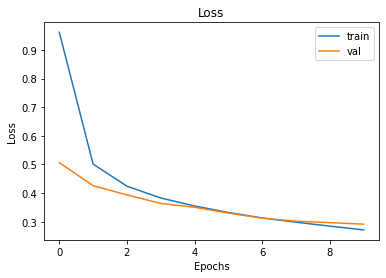

Final Validation Loss: 0.2914


In [16]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()
print('Final Validation Loss: {:.4f}'.format(val_losses[-1]))

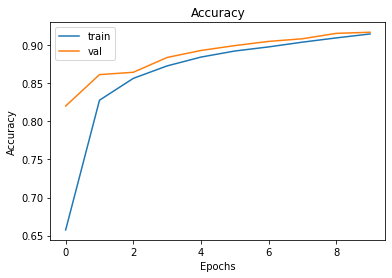

Final Validation Accuracy: 91.71%


In [15]:
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_accuracies, label='train')
plt.plot(val_accuracies, label='val')
plt.legend()
plt.show()
print('Final Validation Accuracy: {:.2f}%'.format(val_accuracies[-1] * 100))